# Importing Preprocessed Data

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('Data Files/preprocessed_meijer_df.csv')

<hr style="border:2px solid #000"/>

# Descriptive Stats

In [4]:
data.head()

,Latitude,Longitude,Visits,Grocery_Stores_1mile,Food_Outlets_1mile,Educational_Institutions_1mile,Residential_Housing_1mile,Commercial_Housing_1mile,Fuel_Stations_Car_Wash_1mile,Hospitals_3miles,Apparels_3miles,Tourist_Destinations_5miles,Hotels_5miles,Airports_5miles,Driving Distance to Nearest Motorway (in miles),Traffic (AADT),Census Block Code,City,State,County,Household_Income_Under50k,Household_Income_50to100k,Household_Income_100to200k,Household_Income_200k+,Population_Male_Under15,Population_Male_15to64,Population_Male_65+,Population_Female_Under15,Population_Female_15to64,Population_Female_65+
0,43.192877,-86.261282,33029,14,29,3,16,19,8,7,1,5,1,6,3.3,13943,1008,Norton Shores,MI,Muskegon County,251,197,61,10,65,390,50,232,447,111
1,43.007961,-85.691687,33513,7,20,0,7,7,5,9,1,5,2,6,0.7,20324,1014,Grand Rapids,MI,Kent County,308,241,420,54,335,1096,201,293,937,150
2,42.323240,-85.515490,37185,6,28,1,75,0,7,2,0,3,0,6,12.3,4852,1008,Kalamazoo,MI,Kalamazoo County,288,95,55,0,104,381,10,0,281,52
3,42.242442,-85.587246,36144,8,24,5,24,4,6,7,9,4,2,6,0.6,32726,4022,Portage,MI,Kalamazoo County,347,164,190,35,90,610,72,94,720,121
4,42.719097,-84.424699,42797,18,40,7,61,81,5,17,4,4,3,1,17.1,6621,1050,Okemos,MI,Ingham County,339,369,363,47,492,836,198,334,1013,55


#### Analyzing Data Distribution

In [6]:
state_counts = data['State'].value_counts()

# To display the counts for each state
print(state_counts)

MI    82
OH    37
IN    32
Name: State, dtype: int64


In [7]:
data.shape[1]

30

In [8]:
data.shape[0]

151

#### Descriptive Stats for Visits

In [9]:
# Display the minimum value of 'visits'
min_visits = data['Visits'].min()
print(f"Minimum visits: {min_visits}")

# Display the maximum value of 'visits'
max_visits = data['Visits'].max()
print(f"Maximum visits: {max_visits}")

# Display the range of 'visits'
range_visits = max_visits - min_visits
print(f"Range of Visits: {range_visits}")

# Display the mean value of 'visits'
mean_visits = data['Visits'].mean()
print(f"Mean visits: {mean_visits}")

# Display the median value of 'visits'
median_visits = data['Visits'].median()
print(f"Median visits: {median_visits}")

# Display the mode value of 'visits' (Note: mode() returns a Series, so we extract the value)
mode_visits = data['Visits'].mode()[0]
print(f"Mode visits: {mode_visits}")

# Display the standard deviation of 'visits'
std_dev_visits = data['Visits'].std()
print(f"Standard Deviation of visits: {std_dev_visits}")

Minimum visits: 17214
Maximum visits: 54147
Range of Visits: 36933
Mean visits: 31850.026490066226
Median visits: 31449.0
Mode visits: 17214
Standard Deviation of visits: 6733.532013187947


<hr style="border:2px solid #000"/>

# Model Building

### Complex Hyper Parameter Tuning using GridSearchCV

#### The Parameter Grid gave the following best hyper-parameters for XG Boost Regressor through GridSearchCV:

***

### Model Built for Different Train-Test Splits

<Figure size 1200x800 with 0 Axes>

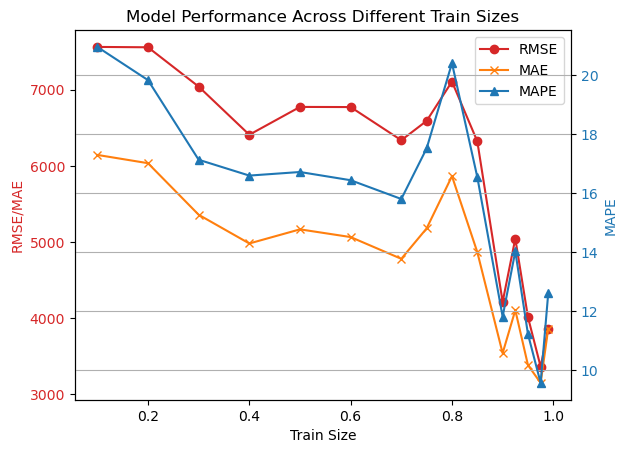

In [10]:
df = data

# Assuming these are your categorical columns
categorical_columns = ['City', 'State', 'County']  # Example, replace with your actual categorical columns

# Label encoding for categorical variables
for col in categorical_columns:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

# Define your feature columns and target variable, excluding 'Latitude', 'Longitude', and 'Visits'
feature_columns = [col for col in df.columns if col not in ['Visits', 'Latitude', 'Longitude', 'State']]  # Exclude specified columns
X = df[feature_columns]
y = df['Visits']


train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 0.99]
mae_scores, mape_scores, rmse_scores = [], [], []

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=42)
    
    # Initialize XGBoost regressor with your specified hyperparameters
    model = XGBRegressor(
        n_estimators=100, 
        learning_rate=0.05,
        max_depth=10,
        min_child_weight=0,
        gamma=0,
        reg_lambda=1.5,
        subsample=0.75,
        alpha=0.5,
        random_state=42
    )
    
    # RFE for feature selection
    selector = RFE(model, n_features_to_select=20, step=1)  # Adjust n_features_to_select as needed
    X_train_rfe = selector.fit_transform(X_train, y_train)
    X_test_rfe = selector.transform(X_test)
    
    # Feature scaling after RFE and split
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_rfe)
    X_test_scaled = scaler.transform(X_test_rfe)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

# Plot
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots()

ax1.set_xlabel('Train Size')
ax1.set_ylabel('RMSE/MAE', color='tab:red')
line1, = ax1.plot(train_sizes, rmse_scores, label='RMSE', color='tab:red', marker='o')
line2, = ax1.plot(train_sizes, mae_scores, label='MAE', color='tab:orange', marker='x')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('MAPE', color='tab:blue')  # we already handled the x-label with ax1
line3, = ax2.plot(train_sizes, mape_scores, label='MAPE', color='tab:blue', marker='^')

# Added lines for combined legend
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

ax1.tick_params(axis='y', labelcolor='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Model Performance Across Different Train Sizes')
plt.grid(True)
plt.show()

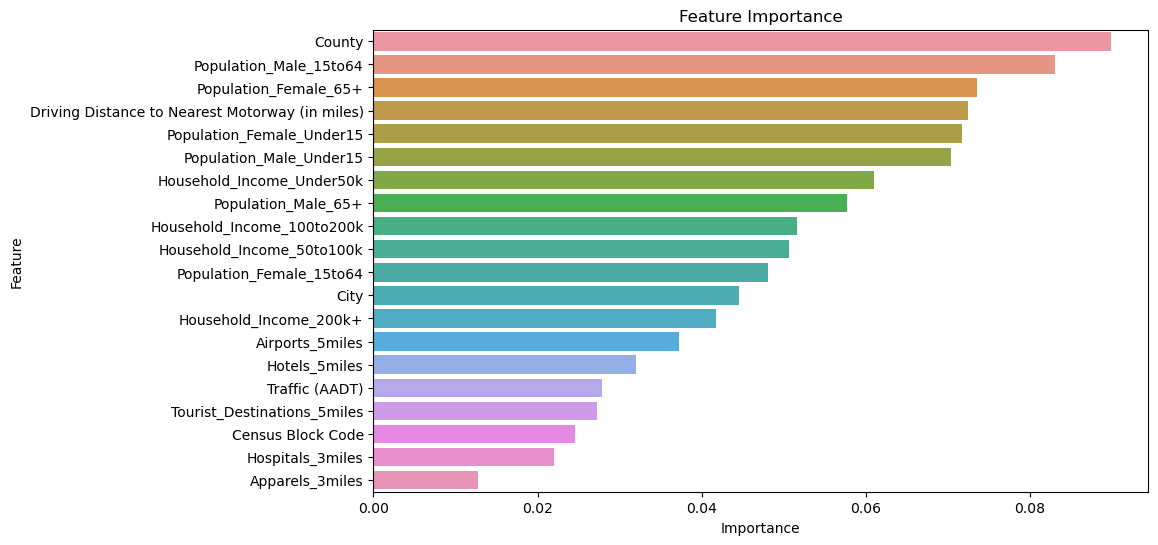

In [11]:
# Map the selected RFE features back to the original feature names
selected_features = [feature for feature, selected in zip(X_train.columns, selector.support_) if selected]

# Get the feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame for easier handling
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [12]:
# Creating a DataFrame for the metrics
metrics_df_splits = pd.DataFrame({
    'Train Size': train_sizes,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE': mape_scores
})

# Display the DataFrame
print("Metrics for Different Train-Test Splits:")
print(metrics_df_splits)

Metrics for Different Train-Test Splits:
    Train Size         RMSE          MAE       MAPE
0        0.100  7559.969853  6142.863310  20.969785
1        0.200  7555.250234  6034.142352  19.842451
2        0.300  7039.299653  5357.849130  17.138101
3        0.400  6407.489177  4980.781035  16.600626
4        0.500  6772.685188  5166.082340  16.722130
5        0.600  6770.718400  5064.775583  16.443013
6        0.700  6335.455550  4779.503227  15.805915
7        0.750  6589.533636  5178.919768  17.524008
8        0.800  7104.732405  5864.234375  20.417659
9        0.850  6321.450644  4867.311311  16.551389
10       0.900  4214.203519  3540.750244  11.810539
11       0.925  5044.753785  4105.700846  14.029566
12       0.950  4013.796400  3384.315430  11.215833
13       0.975  3363.471436  3150.906738   9.559551
14       0.990  3864.897397  3864.485352  12.606104


***

### Cross Validation performed for different Folds

<Figure size 1200x800 with 0 Axes>

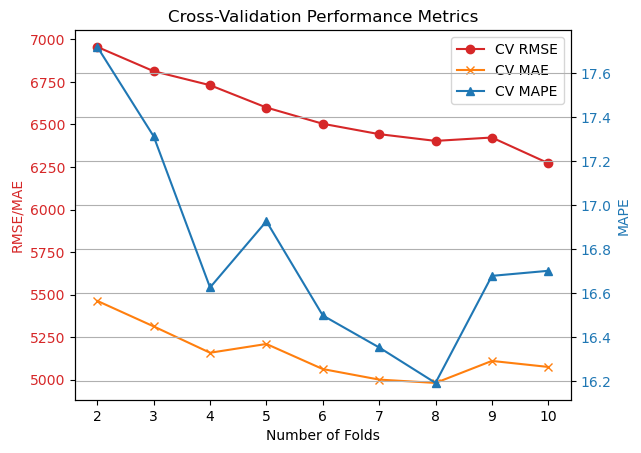

In [13]:
df = data

# Assuming these are your categorical columns
categorical_columns = ['City', 'State', 'County']  # Example, replace with your actual categorical columns

# Label encoding for categorical variables
for col in categorical_columns:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

# Define your feature columns and target variable, excluding 'Latitude', 'Longitude', and 'Visits'
feature_columns = [col for col in df.columns if col not in ['Visits', 'Latitude', 'Longitude', 'State']]  # Exclude specified columns
X = df[feature_columns]
y = df['Visits']

kfolds = range(2, 11)  # From 2 to 10 folds
avg_rmse_scores, avg_mae_scores, avg_mape_scores = [], [], []

model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=0,
    gamma=0,
    reg_lambda=1.5,
    subsample=0.75,
    alpha=0.5,
    random_state=42
)

# Define MAPE scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

for k in kfolds:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Define a pipeline to ensure scaling is done within each fold
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # RMSE
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    avg_rmse_scores.append(-scores.mean())
    
    # MAE
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    avg_mae_scores.append(-scores.mean())
    
    # MAPE
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring=mape_scorer)
    avg_mape_scores.append(-scores.mean())

    
# Plot
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Folds')
ax1.set_ylabel('RMSE/MAE', color='tab:red')
line1, = ax1.plot(kfolds, avg_rmse_scores, label='CV RMSE', color='tab:red', marker='o')
line2, = ax1.plot(kfolds, avg_mae_scores, label='CV MAE', color='tab:orange', marker='x')
ax2 = ax1.twinx()
ax2.set_ylabel('MAPE', color='tab:blue')
line3, = ax2.plot(kfolds, avg_mape_scores, label='CV MAPE', color='tab:blue', marker='^')

# Added lines for combined legend
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.title('Cross-Validation Performance Metrics')
plt.grid(True)
plt.show()

In [14]:
# Creating a DataFrame for the cross-validation metrics
metrics_df_cv = pd.DataFrame({
    'Number of Folds': list(kfolds),
    'CV RMSE': avg_rmse_scores,
    'CV MAE': avg_mae_scores,
    'CV MAPE': avg_mape_scores
})

# Display the DataFrame
print("Cross-Validation Metrics for Different Numbers of Folds:")
print(metrics_df_cv)

Cross-Validation Metrics for Different Numbers of Folds:
   Number of Folds      CV RMSE       CV MAE    CV MAPE
0                2  6955.425742  5463.353762  17.717568
1                3  6812.695710  5313.435111  17.311224
2                4  6730.584003  5158.665291  16.624647
3                5  6599.325569  5210.263525  16.925503
4                6  6503.980725  5062.841931  16.497547
5                7  6442.993398  5000.980529  16.352129
6                8  6403.322515  4981.427445  16.191057
7                9  6423.174584  5110.661710  16.677429
8               10  6272.403072  5075.344895  16.700392


<hr style="border:2px solid #000"/>

# Heuristic Scoring Model

In [15]:
# Updated list of amenities divided into essential and non-essential categories
essential_amenities = [
    'Apparels_3miles', 'Tourist_Destinations_5miles', 'Food_Outlets_1mile',
    'Hotels_5miles', 'Airports_5miles'
]

non_essential_amenities = [
    'Grocery_Stores_1mile', 'Educational_Institutions_1mile',
    'Fuel_Stations_Car_Wash_1mile', 'Hospitals_3miles'
]

# Scoring function for Traffic (scaled based on max observed value for normalization)
def score_traffic(volume, max_traffic):
    return (volume / max_traffic) * 10

# Scoring function for Proximity to Highways
def score_proximity(distance):
    return max(10 - (distance * 2), 0)

# Scoring function for Essential Amenities
def score_essential_amenities(row):
    # Adjust the divisor based on your data for better score distribution
    return min((sum(row[col] for col in essential_amenities) / 10), 10)

# Scoring function for Non-Essential Amenities
def score_non_essential_amenities(row):
    # Adjust the divisor based on your data for better score distribution
    return min((sum(row[col] for col in non_essential_amenities) / 15), 10)

# Scoring function for Demographics (using Population and Income for simplicity)
def score_demographics(row):
    pop_score = min(row['Population_Male_15to64'] / 10000, 5)  # Normalize based on your data range
    income_score = min(row['Population_Female_15to64'] / 10000, 5)  # Normalize based on your data range
    return pop_score + income_score

# Assuming 'data' is your DataFrame containing all the relevant columns
# Calculate scores and add them to the DataFrame
max_traffic = data['Traffic (AADT)'].max()  # Find the maximum traffic value for normalization
data['Traffic_Score'] = data['Traffic (AADT)'].apply(lambda x: score_traffic(x, max_traffic))
data['Proximity_Score'] = data['Driving Distance to Nearest Motorway (in miles)'].apply(score_proximity)
data['Essential_Amenities_Score'] = data.apply(score_essential_amenities, axis=1)
data['Non_Essential_Amenities_Score'] = data.apply(score_non_essential_amenities, axis=1)
data['Demographics_Score'] = data.apply(score_demographics, axis=1)

# Define weights based on your correlation coefficients and requirements
# The following weights should be normalized based on their relative importance
weights = {
    'Traffic': 0.25,  # Example weight, adjust based on your analysis
    'Proximity': 0.25, 
    'Essential_Amenities': 0.20,  
    'Non_Essential_Amenities': 0.10,  
    'Demographics': 0.20 
}

# Calculate the final heuristic score
data['Heuristic_Score'] = (
    data['Traffic_Score'] * weights['Traffic'] +
    data['Proximity_Score'] * weights['Proximity'] +
    data['Essential_Amenities_Score'] * weights['Essential_Amenities'] +
    data['Non_Essential_Amenities_Score'] * weights['Non_Essential_Amenities'] +
    data['Demographics_Score'] * weights['Demographics']
)

In [16]:
data.head()

,Latitude,Longitude,Visits,Grocery_Stores_1mile,Food_Outlets_1mile,Educational_Institutions_1mile,Residential_Housing_1mile,Commercial_Housing_1mile,Fuel_Stations_Car_Wash_1mile,Hospitals_3miles,Apparels_3miles,Tourist_Destinations_5miles,Hotels_5miles,Airports_5miles,Driving Distance to Nearest Motorway (in miles),Traffic (AADT),Census Block Code,City,State,County,Household_Income_Under50k,Household_Income_50to100k,Household_Income_100to200k,Household_Income_200k+,Population_Male_Under15,Population_Male_15to64,Population_Male_65+,Population_Female_Under15,Population_Female_15to64,Population_Female_65+,Traffic_Score,Proximity_Score,Essential_Amenities_Score,Non_Essential_Amenities_Score,Demographics_Score,Heuristic_Score
0,43.192877,-86.261282,33029,14,29,3,16,19,8,7,1,5,1,6,3.3,13943,1008,89,1,48,251,197,61,10,65,390,50,232,447,111,1.051223,3.4,4.2,2.133333,0.0837,2.182879
1,43.007961,-85.691687,33513,7,20,0,7,7,5,9,1,5,2,6,0.7,20324,1014,42,1,32,308,241,420,54,335,1096,201,293,937,150,1.532314,8.6,3.4,1.400000,0.2033,3.393739
2,42.323240,-85.515490,37185,6,28,1,75,0,7,2,0,3,0,6,12.3,4852,1008,57,1,31,288,95,55,0,104,381,10,0,281,52,0.365813,0.0,3.7,1.066667,0.0662,0.951360
3,42.242442,-85.587246,36144,8,24,5,24,4,6,7,9,4,2,6,0.6,32726,4022,96,1,31,347,164,190,35,90,610,72,94,720,121,2.467354,8.8,4.5,1.733333,0.1330,3.916772
4,42.719097,-84.424699,42797,18,40,7,61,81,5,17,4,4,3,1,17.1,6621,1050,90,1,26,339,369,363,47,492,836,198,334,1013,55,0.499186,0.0,5.2,3.133333,0.1849,1.515110
